# Project: Investigate a Dataset noshow_final_processed

### 1. Library Imports
In this section, we import the necessary Python libraries for data manipulation and numerical analysis. We use `pandas` for data handling and `numpy` for mathematical operations.

In [69]:
import pandas as pd
import numpy as np

.

### 2. Data Loading
The dataset containing medical appointment no-show information is loaded into a pandas DataFrame from the CSV file.

In [70]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Initial Data Inspection
We display the first five rows of the dataset to understand the structure of the data, identify the column names, and verify that the file was loaded correctly.

**Age Impact:** Does a patient's age correlate with their likelihood of missing an appointment?

**SMS Reminders:** How effective are SMS notifications in reducing the number of missed appointments?

we will answer that question later

### Convert ScheduledDay and AppointmentDay to datetime objects.

In [71]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

print(df[['ScheduledDay', 'AppointmentDay']].dtypes)
df[['ScheduledDay', 'AppointmentDay']].head()

ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
dtype: object


,ScheduledDay,AppointmentDay
0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00
1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00
2,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00
3,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00
4,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00


The `ScheduledDay` and `AppointmentDay` columns are currently stored as strings. We convert them into datetime objects to facilitate time-based analysis.

### Handle the erroneous -1 age value.

In [72]:
erroneous_age_count = df[df['Age'] < 0].shape[0]
print(f"Removing {erroneous_age_count} records with with age < 0.")

df = df[df['Age'] >= 0]

print(f"New minimum age: {df['Age'].min()}")

Removing 1 records with with age < 0.
New minimum age: 0


During data exploration, an invalid age value of -1 was identified. We remove these records to maintain data integrity and verify the new minimum age.

### Standardize column names

In [73]:
def standardize_columns(dataframe):
    rename_map = {
        'Hipertension': 'hypertension',
        'Handcap': 'handicap',
        'No-show': 'no_show',
        'PatientId': 'patient_id',
        'AppointmentID': 'appointment_id'
    }
    df.rename(columns=rename_map, inplace=True)
    df.columns = df.columns.str.lower()
    return df

df = standardize_columns(df)
print(df.columns)

Index(['patient_id', 'appointment_id', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hypertension',
       'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show'],
      dtype='object')


To improve consistency and accessibility, we correct typos in column names (e.g., 'Hipertension' to 'Hypertension') and convert all column headers to lowercase.

#### Calculate the Waiting Time (days between booking and appointment)

In [74]:
df['waiting_days'] = (df['appointmentday'].dt.normalize() - df['scheduledday'].dt.normalize()).dt.days
df = df[df['waiting_days'] >= 0]

df['day_of_week'] = df['appointmentday'].dt.day_name()
df.head()

,patient_id,appointment_id,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,waiting_days,day_of_week
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,Friday
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,Friday
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,Friday
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,Friday
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,Friday


We create a new feature, `waiting_days`, by calculating the difference between the appointment date and the scheduled date. We also extract the day of the week for further analysis.

.

In [75]:
df['no_show_num'] = df['no_show'].apply(lambda x: 1 if x == 'Yes' else 0)

Transform the categorical no_show column into a binary numeric format (1 for Yes, 0 for No) for analysis.

In [76]:
import matplotlib.pyplot as plt

def apply_plot_labels(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

this function added tittle and labels it can be used with each plot in the notebook

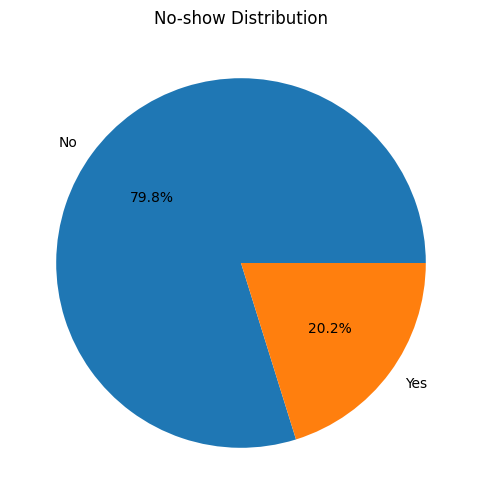

In [77]:
ax1 = df['no_show'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    figsize=(6, 6)
)
apply_plot_labels('No-show Distribution', '', '')

the code is analyzing the distribution of a categorical variable named no_show and rendering it as a pie chart.

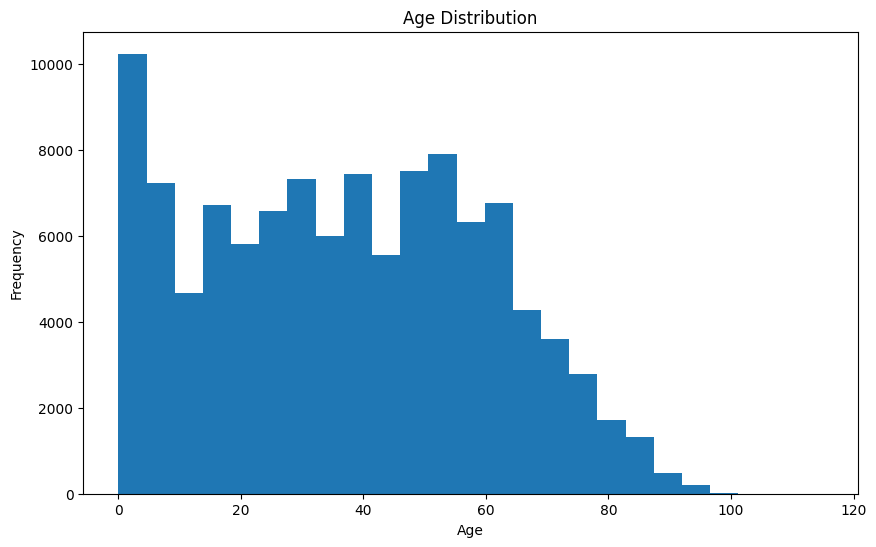

In [ ]:

ax2 = df['age'].plot(
    kind='hist', 
    bins=25, 
    figsize=(10, 6)
)

apply_plot_labels('Age Distribution', 'Age', 'Frequency')

the code generating a histogram to visualize the spread of ages in the dataset.
A histogram was chosen because Age is a continuous numerical variable. This visualization allows us to see the shape of the distribution, identify the most common age groups, and spot any outliers

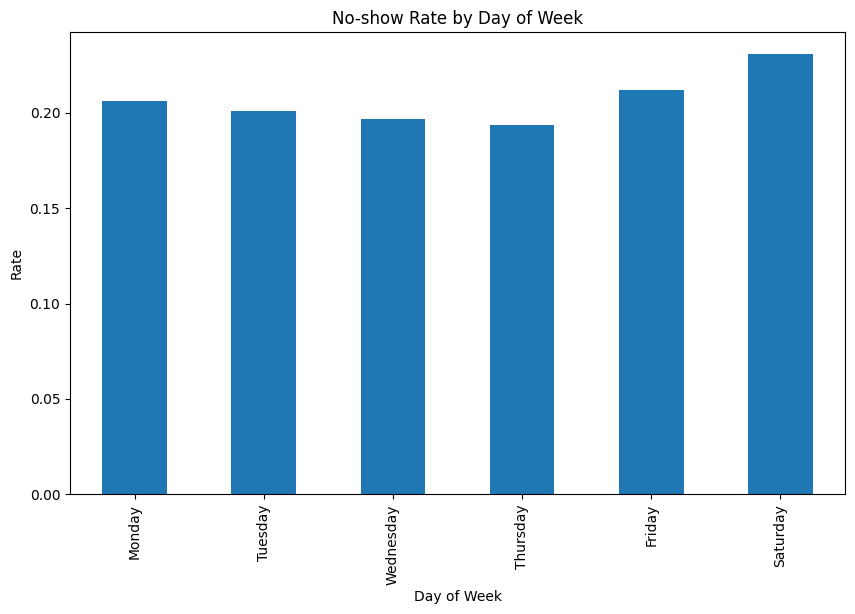

In [ ]:

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
ax3 = df.groupby('day_of_week')['no_show_num'].mean().reindex(day_order).plot(
    kind='bar', 
    figsize=(10, 6)
)

apply_plot_labels('No-show Rate by Day of Week', 'Day of Week', 'Rate')


the code focus from simple distributions to relational analysis. It examines how the day of the week might influence whether a person shows up for their appointment.

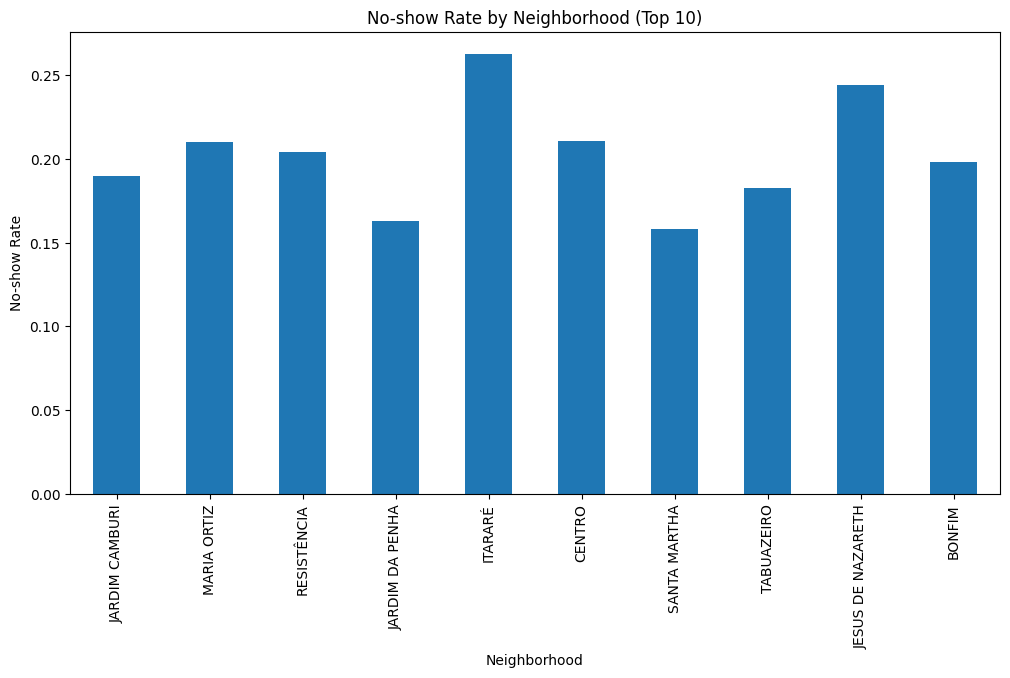

In [ ]:
top_neighborhoods = df['neighbourhood'].value_counts().nlargest(10).index
ax4 = df[df['neighbourhood'].isin(top_neighborhoods)].groupby('neighbourhood')['no_show_num'].mean().reindex(top_neighborhoods).plot(
    kind='bar', 
    figsize=(12, 6)
)
apply_plot_labels('No-show Rate by Neighborhood (Top 10)', 'Neighborhood', 'No-show Rate')


Geographic Variance To see if location is a factor, the no-show rates were analyzed for the most active neighborhoods.

In [ ]:
df.to_csv('noshow_final_processed.csv', index=False)
df.head()

,patient_id,appointment_id,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,waiting_days,day_of_week,no_show_num
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,Friday,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,Friday,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,Friday,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,Friday,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,Friday,0


## Q1 : **Age Impact:** Does a patient's age correlate with their likelihood of missing an appointment?

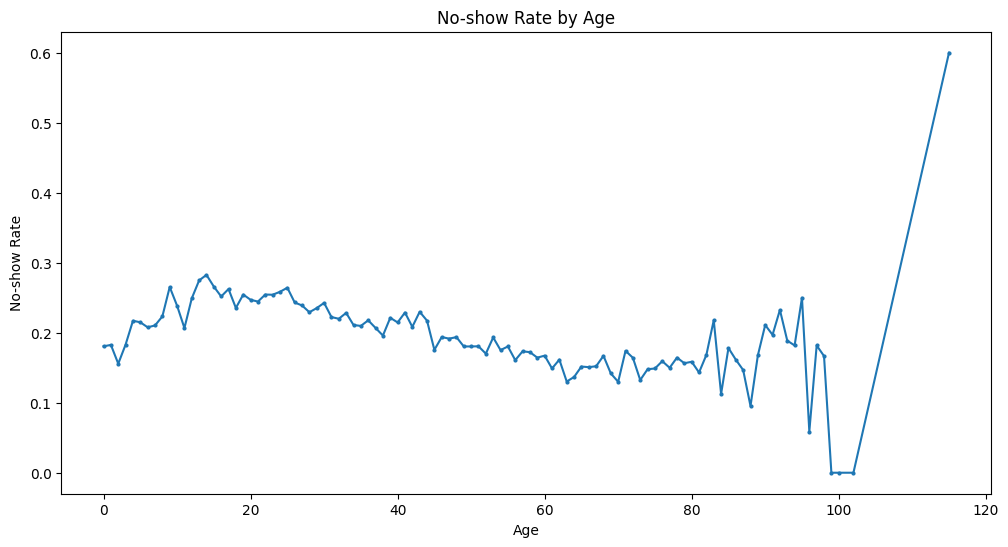

In [82]:
age_analysis = df.groupby('age')['no_show_num'].mean()

ax_age = age_analysis.plot(kind='line', figsize=(12, 6), marker='o', markersize=2)
apply_plot_labels('No-show Rate by Age', 'Age', 'No-show Rate')

## Q2 : **SMS Reminders:** How effective are SMS notifications in reducing the number of missed appointments?

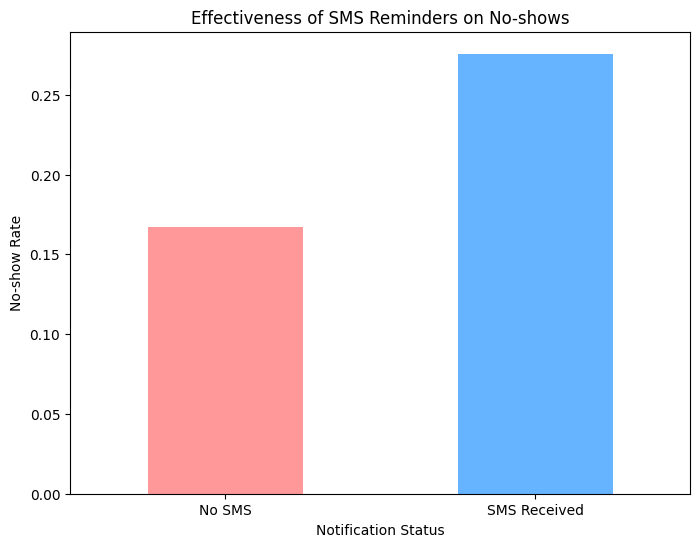

In [83]:
sms_analysis = df.groupby('sms_received')['no_show_num'].mean()
ax_sms = sms_analysis.plot(kind='bar', figsize=(8, 6), color=['#ff9999','#66b3ff'])
ax_sms.set_xticklabels(['No SMS', 'SMS Received'], rotation=0)
apply_plot_labels(
    'Effectiveness of SMS Reminders on No-shows', 
    'Notification Status', 
    'No-show Rate'
)


# Final Conclusion

#### In this investigation, we explored the factors influencing patient no-shows for medical appointments using a dataset of over 110,000 records. We specifically addressed two research questions:

#### Age Impact: Does a patient's age correlate with their likelihood of missing an appointment?

#### SMS Reminders: How effective are SMS notifications in reducing the number of missed appointments?

Age and Attendance: Younger patients and infants are more likely to miss appointments; no-show rates decrease with age.

Waiting Time Impact: Longer gaps between booking and appointment increase no-show likelihood; same-day appointments have the highest attendance.

SMS Effectiveness: Patients who received SMS reminders showed higher no-show rates, likely because reminders were sent for appointments with longer waiting times rather than the SMS causing the absence.